In [208]:
import pandas as pd
import numpy as np
import re
import seaborn as sns
import math
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
import statsmodels.formula.api as smf
from statsmodels.graphics.gofplots import ProbPlot
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import sklearn as sk
from sklearn.linear_model import LassoCV
from sklearn.metrics import r2_score

In [91]:
#read in pickle file of warcraft logs data.
df = pd.read_pickle('wowlogs_data_v2.pkl')

# Data Cleaning

First we can drop rows with weird errors related to class/spec data. There are only about 20 rows like this.

In [92]:
df_clean = df[df['specs-warcraft.unknown (specs-warcraft.unknown_null)'].isna()]
df_clean = df_clean[df_clean['specs-warcraft.unknown (specs-warcraft.unknown_protection)'].isna()]
df_clean = df_clean[df_clean['Warrior (specs-warcraft.warrior_null)'].isna()]
#df_clean = df_clean[df_clean['specs-warcraft.unknown (specs-warcraft.unknown_fire)'].isna()]
df_clean = df_clean[df_clean['Shaman (specs-warcraft.shaman_null)'].isna()]
df_clean = df_clean[df_clean['Mage (specs-warcraft.mage_null)'].isna()]
df_clean = df_clean[df_clean['Priest (specs-warcraft.priest_null)'].isna()]
df_clean = df_clean[df_clean['Druid (specs-warcraft.druid_null)'].isna()]
df_clean = df_clean[df_clean['Warlock (specs-warcraft.warlock_null)'].isna()]
df_clean = df_clean[df_clean['Paladin (specs-warcraft.paladin_null)'].isna()]
df_clean = df_clean[df_clean['Rogue (specs-warcraft.rogue_null)'].isna()]

df_clean =df_clean.dropna(axis=1, how='all')

In [93]:
df_clean.isna().sum()

boss                        0
kill                        0
fight_time                  0
tank_avg_ilvl              40
dps_avg_ilvl                3
heals_avg_ilvl              3
world_buffs                 0
Warrior (Protection)      175
Hunter (Marksmanship)      89
Mage (Frost)               81
Rogue (Assassination)      41
Warlock (Destruction)     135
Warrior (Fury)             83
Druid (Restoration)       737
Paladin (Holy)           2407
Priest (Holy)              29
Mage (Fire)              4349
Shaman (Restoration)     2352
Druid (Balance)          4176
Priest (Shadow)          3008
Druid (Guardian)         3436
Druid (Feral)            2974
Shaman (Enhancement)     3735
Paladin (Retribution)    4065
Paladin (Protection)     4619
Shaman (Elemental)       4408
dtype: int64

This Looks good so far. There will obviously be NAs for the class specific columns as groups likely wont have at least 1 of every class in a raid. We already see that some classes are almost always present (holy priest, frost mage, assasination rogues etc.) It seems odd that the item level fields would be missing, so they might have been some errors. We do have all of our target variable in fight_time so that is good, as well as kill and boss columns.

I do want to make sure that we are only looking at Onyxia fight data.

In [94]:
df_clean['boss'].unique()

array(['Onyxia'], dtype=object)

That checks out. I also want to make sure we are only looking at completed fights in this case. It could be interesting to add a classification model to predict if a group will likely defeat the boss or not. However that is not the goal of this project.

The column indicating if it is a kill is a bit messy with extra information. We can clean this up and take the numbers of attempts and see if it ends up being helpful.

In [95]:
df_clean['kill'].unique()

array(['Last Pull - Kill', 'Wipe', 'Kill', 'Kill 3', 'Last Pull - Wipe',
       'Last Pull - Wipe 2', 'Last Pull - Kill 2', 'Kill 4', 'Kill 2',
       'Last Pull - Invalid Log', 'Last Pull - Kill 3', 'Kill 9',
       'Last Pull - Kill 4', 'Last Pull - Wipe 3', 'Wipe 2',
       'Invalid Log', 'Last Pull - Wipe 4', 'Kill 6',
       'Last Pull - Wipe 6', 'Last Pull - Kill 7', 'Kill 5', 'Kill 12',
       'Last Pull - Kill 5', 'Kill 7', 'Kill 8', 'Kill 15', 'Kill 11',
       'Kill 13', 'Last Pull - Kill 10', 'Kill 16', 'Last Pull - Wipe 5',
       'Last Pull - Wipe 7', 'Last Pull - Kill 6', 'Wipe 4'], dtype=object)

In [96]:
# Create a column with number of attempts extracted from the string.
df_clean['attempts'] = df_clean['kill'].apply(lambda x: int(re.findall('\d+', x)[0]) if re.findall('\d+', x) else 1 )

We want to know which rows contain logs for groups that have killed the boss, and those which were not successful. 

In [97]:
def is_kill(st):
    '''
    A quick function to simplify the given string to determing if the group killed onyxia or not.
    '''
    
    if 'Kill' in st:
        return('kill')
    else:
        return('wipe')

# apply this to the column
df_clean['kill']=df_clean['kill'].apply(lambda x:'kill' if re.search('Kill',x) else 'wipe')

# filter the data to include kills only
df_clean = df_clean[df_clean.kill=='kill']

In [98]:
#replace nan with 0, NaNs in our data should generally indicate the absense of a class or even a role (tank/dps/healer)
df_clean = df_clean.fillna(0)

# Creating potentially useful features.

In [99]:
# Add Raid size as the total of all present classes in the raid
df_clean['raid_size'] = df_clean[['Warrior (Protection)',
                                  'Hunter (Marksmanship)',
                                  'Mage (Frost)',
                                  'Rogue (Assassination)',
                                  'Warlock (Destruction)',
                                  'Warrior (Fury)',
                                  'Druid (Restoration)',
                                  'Paladin (Holy)',
                                  'Priest (Holy)',
                                  'Mage (Fire)',
                                  'Shaman (Restoration)',
                                  'Druid (Balance)',
                                  'Priest (Shadow)',
                                  'Druid (Guardian)',
                                  'Druid (Feral)',
                                  'Shaman (Enhancement)',
                                  'Paladin (Retribution)',
                                  'Paladin (Protection)',
                                  'Shaman (Elemental)']].sum(axis=1)

# Sum all of the classes that fall into the DPS category
df_clean['dps_num'] = df_clean[['Hunter (Marksmanship)',
                                'Mage (Frost)',
                                'Rogue (Assassination)',
                                'Warlock (Destruction)',
                                'Warrior (Fury)',
                                'Mage (Fire)',
                                'Druid (Balance)',
                                'Priest (Shadow)',
                                'Shaman (Enhancement)',
                                'Paladin (Retribution)',
                                'Shaman (Elemental)']].sum(axis=1)

# Sum all of the classes that fall into the TANK category
df_clean['tank_num'] = df_clean[['Warrior (Protection)',
                                  'Druid (Guardian)',
                                  'Paladin (Protection)']].sum(axis=1)

# Sum all of the classes that fall into the HEALER category
df_clean['heals_num'] = df_clean[['Druid (Restoration)',
                                  'Paladin (Holy)',
                                  'Priest (Holy)',
                                  'Shaman (Restoration)']].sum(axis=1)


# Find the estimated number of world buffs per person
df_clean['buff_pp'] =  df_clean['world_buffs']/df_clean['raid_size']

I also want to convert time to seconds to make it a bit easier to work with.

In [100]:
def get_sec(time_str):
    """Get Seconds from time."""
    m, s = time_str.split(':')
    return int(m) * 60 + int(s)

df_clean['fight_time_s']=df_clean['fight_time'].apply(lambda x:get_sec(x))

In [101]:
# Because multiple people in a raid can submit logs from the same raid, we can try and remove ones that look like
# they are the same. This currently removes about 500 rows.

df_clean = df_clean[~df_clean.duplicated(subset=['kill',
                                                 'fight_time',
                                                 'tank_avg_ilvl',
                                                 'dps_avg_ilvl',
                                                 'heals_avg_ilvl',
                                                 'world_buffs',
                                                 'raid_size',], keep=False)]

#Another issue that I found throwing things off is where all item levels are 0
mask = (df_clean['tank_avg_ilvl']>0) & (df_clean['heals_avg_ilvl']>0) & (df_clean['dps_avg_ilvl']>0)
df_clean = df_clean[mask]

In [102]:
df_clean.shape

(4114, 33)

In [ ]:
We should now have a very useful data set and can start some EDA to see what we can figure out.

In [ ]:
#df_clean=df_clean[df_clean.fight_time_s <=900]

# EDA

First let's take a look at the target variable.

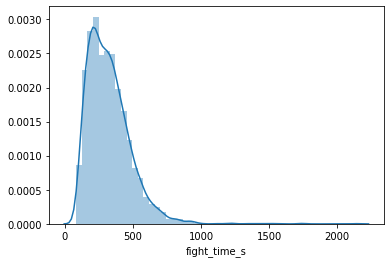

In [103]:
sns.distplot(df_clean['fight_time_s'])

In [104]:
df_clean['fight_time_s'].describe()

count    4114.000000
mean      324.601361
std       159.026601
min        84.000000
25%       210.000000
50%       300.000000
75%       407.750000
max      2141.000000
Name: fight_time_s, dtype: float64

The fight time in seconds seems to have a fairly big right skew. We can address this potentially by looking at a log transformation, as well as removing some outliers.

The 75 percentile starts at 407 seconds but goes all the way up to a maximum of 2141 or over 35 minutes. That strikes me as strange given the average time is closer to 5 minutes.

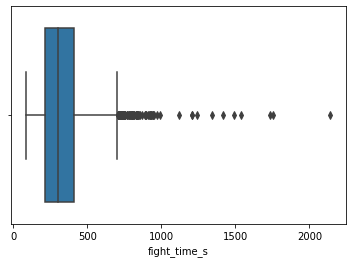

In [105]:
sns.boxplot(df_clean['fight_time_s'])

In the context of this project, where the model would be used to determine how a boss fight scales based on the projected ability of the group, I don't want to overtune it to be accurate to weird examples. It looks like we can probably cut off times around 1000 but first I'd like to look at the outliers.

In [106]:
df_clean[df_clean.fight_time_s>=1000]

boss  kill fight_time  tank_avg_ilvl  \
/reports/1zqKf2jvCJbgG4DA  Onyxia  kill      20:04           62.0   
/reports/KMPkqm98wxT1X6rf  Onyxia  kill      18:40           71.0   
/reports/fDX2hjGCd87kB1w9  Onyxia  kill      23:35           73.0   
/reports/ZvBX86FWx2CMnczb  Onyxia  kill      28:51           73.0   
/reports/rLchMDR7bQp1TKwF  Onyxia  kill      29:12           67.5   
/reports/kYvabNRpA6jxwhft  Onyxia  kill      35:41           72.0   
/reports/3k9TbzWAdNtBy1Jw  Onyxia  kill      25:36           65.0   
/reports/f8hM6ybZwDzaA4Jv  Onyxia  kill      24:47           69.0   
/reports/wTJXY2rHRf9hFByz  Onyxia  kill      20:38           69.0   
/reports/hyCLG6pj7va2mnQk  Onyxia  kill      22:24           62.0   
/reports/DZ1VbqhXnWfQFpmd  Onyxia  kill      20:09           67.0   

                           dps_avg_ilvl  heals_avg_ilvl  world_buffs  \
/reports/1zqKf2jvCJbgG4DA     61.562500       63.875000            0   
/reports/KMPkqm98wxT1X6rf     54.090909       71.500000            0   
/reports/fDX2hjGCd87kB1w9     67.000000       67.333333           14   
/reports/ZvBX86FWx2CMnczb     67.500000       67.500000            3   
/reports/rLchMDR7bQp1TKwF     65.777778       70.000000            0   
/reports/kYvabNRpA6jxwhft     72.000000       71.500000            0   
/reports/3k9TbzWAdNtBy1Jw     62.000000       66.250000            0   
/reports/f8hM6ybZwDzaA4Jv     63.428571       63.400000            0   
/reports/wTJXY2rHRf9hFByz     56.833333       68.200000            0   
/reports/hyCLG6pj7va2mnQk     65.285714       66.333333            0   
/reports/DZ1VbqhXnWfQFpmd     65.600000       64.333333            0   

                           Warrior (Protection)  Hunter (Marksmanship)  \
/reports/1zqKf2jvCJbgG4DA                   2.0                    2.0   
/reports/KMPkqm98wxT1X6rf                   2.0                    3.0   
/reports/fDX2hjGCd87kB1w9                   1.0                    1.0   
/reports/ZvBX86FWx2CMnczb                   1.0                    2.0   
/reports/rLchMDR7bQp1TKwF                   1.0                    2.0   
/reports/kYvabNRpA6jxwhft                   1.0                    2.0   
/reports/3k9TbzWAdNtBy1Jw                   1.0                    2.0   
/reports/f8hM6ybZwDzaA4Jv                   1.0                    1.0   
/reports/wTJXY2rHRf9hFByz                   2.0                    3.0   
/reports/hyCLG6pj7va2mnQk                   2.0                    2.0   
/reports/DZ1VbqhXnWfQFpmd                   1.0                    0.0   

                           Mage (Frost)  ...  Paladin (Retribution)  \
/reports/1zqKf2jvCJbgG4DA           8.0  ...                    0.0   
/reports/KMPkqm98wxT1X6rf           3.0  ...                    0.0   
/reports/fDX2hjGCd87kB1w9           1.0  ...                    0.0   
/reports/ZvBX86FWx2CMnczb           0.0  ...                    0.0   
/reports/rLchMDR7bQp1TKwF           3.0  ...                    0.0   
/reports/kYvabNRpA6jxwhft           0.0  ...                    0.0   
/reports/3k9TbzWAdNtBy1Jw           3.0  ...                    0.0   
/reports/f8hM6ybZwDzaA4Jv           2.0  ...                    0.0   
/reports/wTJXY2rHRf9hFByz           3.0  ...                    0.0   
/reports/hyCLG6pj7va2mnQk           3.0  ...                    0.0   
/reports/DZ1VbqhXnWfQFpmd           2.0  ...                    0.0   

                           Paladin (Protection)  Shaman (Elemental)  attempts  \
/reports/1zqKf2jvCJbgG4DA                   0.0                 0.0         1   
/reports/KMPkqm98wxT1X6rf                   0.0                 0.0         1   
/reports/fDX2hjGCd87kB1w9                   0.0                 0.0         1   
/reports/ZvBX86FWx2CMnczb                   0.0                 0.0         1   
/reports/rLchMDR7bQp1TKwF                   0.0                 0.0         1   
/reports/kYvabNRpA6jxwhft                   0.0                 0.0         1   
/reports/3k9TbzWAdNtBy1Jw 

For the most part these groups seem to be on the small side, being below the 25 player mark.

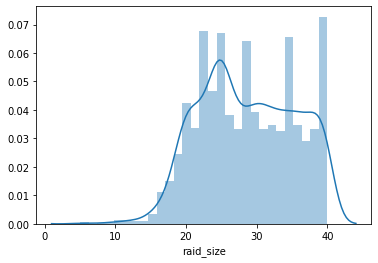

In [108]:
sns.distplot(df_clean['raid_size'])

Since the group sized are generally above 20 I think it is reasonable to remove these outlier cases.

In [110]:
df_clean = df_clean[df_clean.fight_time_s<=1000]

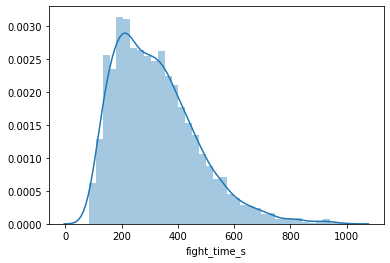

In [111]:
sns.distplot(df_clean['fight_time_s'])

Takeing a log of time should make it a bit more of a normal distribution. Something to consider later.

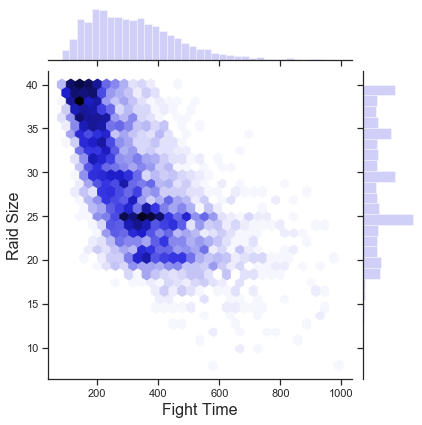

In [112]:
sns.set(style="ticks")
x = df_clean['fight_time_s']
y = df_clean['raid_size']
ch = sns.jointplot(x, y, kind="hex", color="#8787ED")

ch.set_axis_labels('Fight Time','Raid Size', fontsize=16)

In [124]:
#%config InlineBackend.figure_formats = ['png']

#g = sns.PairGrid(df_clean, diag_sharey=False, corner=True)
#g.map_lower(sns.scatterplot)
#g.map_diag(sns.distplot, kde=False)

Running the pairs plot is very unwieldy but helpful for looking at potential useful features and transformations. I will a smaller version below with some of the more obvious relationships.

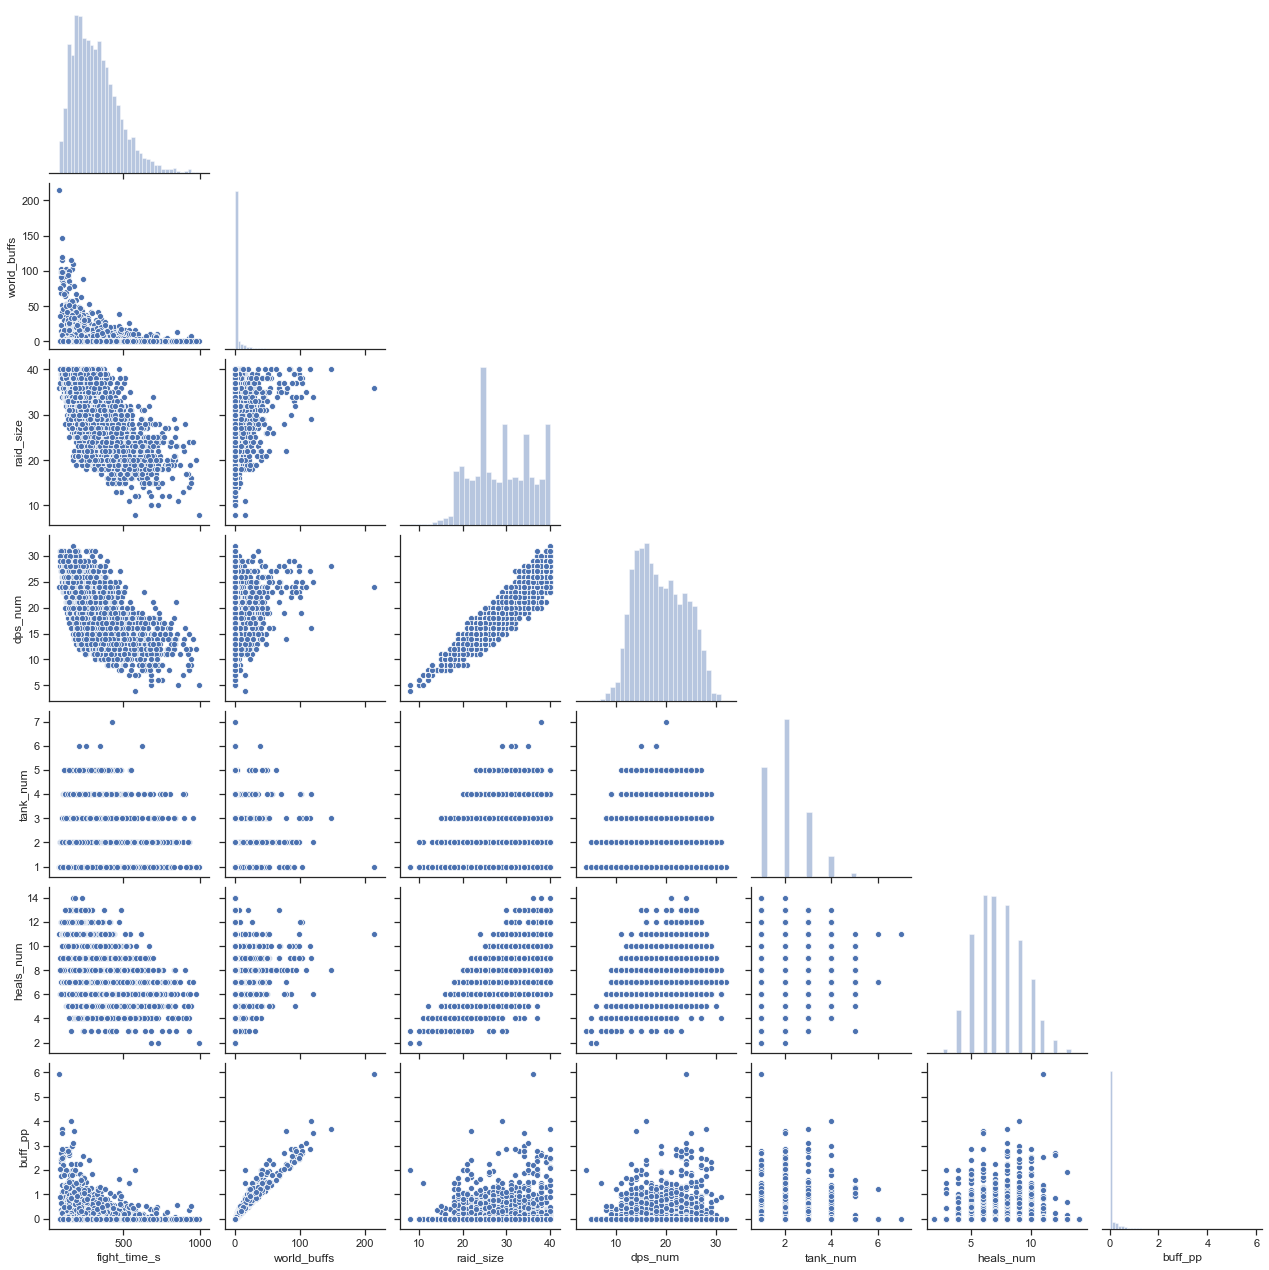

In [128]:
%config InlineBackend.figure_formats = ['png']

df_pairs = df_clean[['fight_time_s','world_buffs','raid_size','dps_num', 'tank_num', 'heals_num', 'buff_pp']]
g = sns.PairGrid(df_pairs, diag_sharey=False, corner=True)
g.map_lower(sns.scatterplot)
g.map_diag(sns.distplot, kde=False)

It seems like raid size and the various features based on number of players have a somewhat linear relationship to the fight time, which of course makes sense. World buffs seem like they might have a non linear relationship so we can consider adjusting.

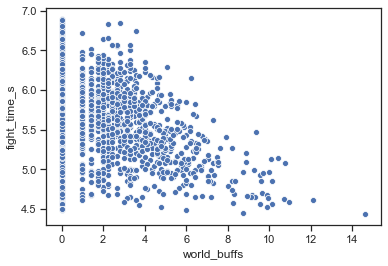

In [136]:
sns.scatterplot(df_clean['world_buffs']**(1/2),np.log(df_clean['fight_time_s']))

Taking a square root of world buffs and the log of fight_time seems to help a bit.

In [175]:
df_clean['world_buff_sqrt'] = df_clean['world_buffs']**(1/2)

I want to take a look at class diversity for part of this project due to my focus on finding way o potentially improve replayability of the game.

In [137]:
#make sub dataframes for the various raid roles.

df_class_dps = df_clean[['Hunter (Marksmanship)',
                                'Mage (Frost)',
                                'Rogue (Assassination)',
                                'Warlock (Destruction)',
                                'Warrior (Fury)',
                                'Mage (Fire)',
                                'Druid (Balance)',
                                'Priest (Shadow)',
                                'Shaman (Enhancement)',
                                'Paladin (Retribution)',
                                'Shaman (Elemental)']].sum()

# Sum all of the classes that fall into the TANK category
df_class_tank = df_clean[['Warrior (Protection)',
                                  'Druid (Guardian)',
                                  'Paladin (Protection)']].sum()

# Sum all of the classes that fall into the HEALER category
df_class_heals = df_clean[['Druid (Restoration)',
                                  'Paladin (Holy)',
                                  'Priest (Holy)',
                                  'Shaman (Restoration)']].sum()

[Text(0, 0, 'Mage (Frost)'),
 Text(0, 0, 'Warrior (Fury)'),
 Text(0, 0, 'Rogue (Assassination)'),
 Text(0, 0, 'Hunter (Marksmanship)'),
 Text(0, 0, 'Warlock (Destruction)'),
 Text(0, 0, 'Priest (Shadow)'),
 Text(0, 0, 'Shaman (Enhancement)'),
 Text(0, 0, 'Mage (Fire)'),
 Text(0, 0, 'Paladin (Retribution)'),
 Text(0, 0, 'Druid (Balance)'),
 Text(0, 0, 'Shaman (Elemental)')]

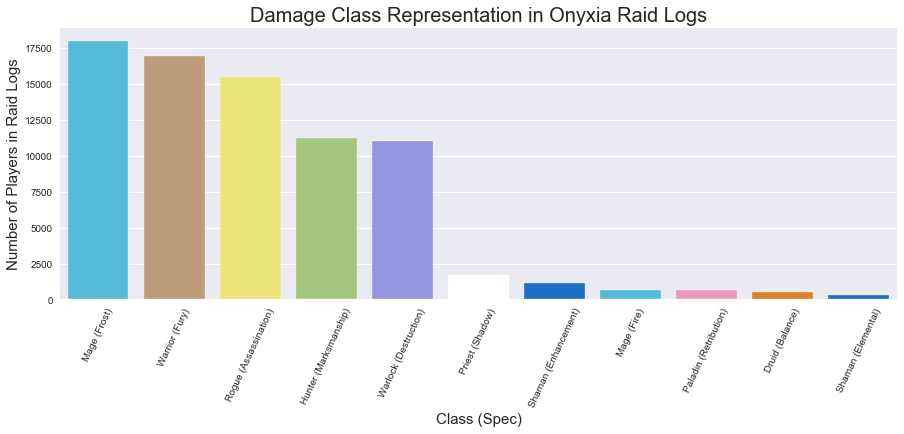

In [139]:
# sort by most representation for DPS classes.
df_class_dps =df_class_dps.sort_values(ascending=False)
plt.style.use('seaborn')

# Create an array with the branded class colors
colors = ['#40C7EB','#C79C6E','#FFF569','#A9D271','#8787ED','#FFFFFF','#0070DE','#40C7EB','#F58CBA','#FF7D0A','#0070DE']
customPalette = sns.color_palette(colors)

plt.figure(figsize=(15,5))
chart = sns.barplot(x=df_class_dps.index,
                    y=df_class_dps.values,
                   palette=customPalette)
plt.xlabel("Class (Spec)",size=15)
plt.ylabel("Number of Players in Raid Logs",size=15)
plt.title("Damage Class Representation in Onyxia Raid Logs", size=20)
chart.set_xticklabels(chart.get_xticklabels(), rotation=65)


We can see that the top 5 classes shown are heavily represented while other classes see almost no play. It is generally known that currently in WoW classic frost mage and fury war are by the far the highest damage dealing classes. In addition the classes shown here have other abilities that provide utility to the group as a whole.

From the perspective of game design, this demonstrates a potentially overwhelming class inbalance that causes groups attempting to do end game content to exclude classes on the right side of the chart.

[Text(0, 0, 'Priest (Holy)'),
 Text(0, 0, 'Shaman (Restoration)'),
 Text(0, 0, 'Druid (Restoration)'),
 Text(0, 0, 'Paladin (Holy)')]

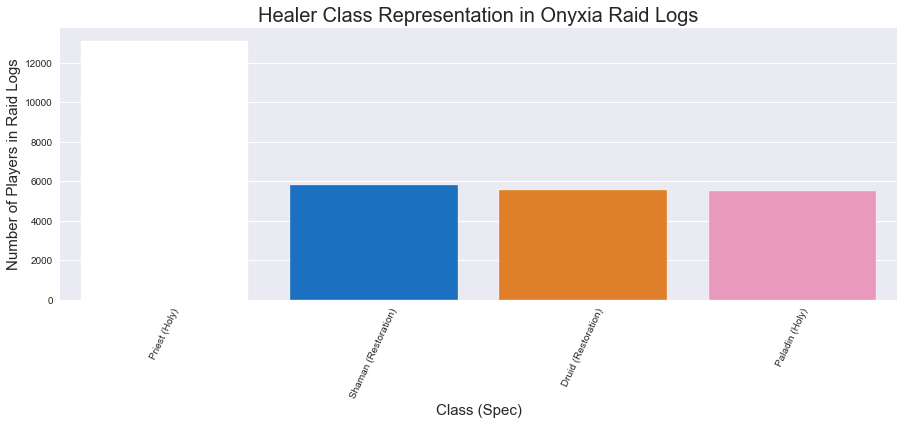

In [144]:
df_class_heals =df_class_heals.sort_values(ascending=False)

# Create an array with the colors you want to use
colors = ['#FFFFFF','#0070DE','#FF7D0A','#F58CBA']
customPalette = sns.color_palette(colors)

plt.figure(figsize=(15,5))
chart = sns.barplot(x=df_class_heals.index,
                    y=df_class_heals.values,
                   palette=customPalette)
plt.xlabel("Class (Spec)",size=15)
plt.ylabel("Number of Players in Raid Logs",size=15)
plt.title("Healer Class Representation in Onyxia Raid Logs", size=20)
chart.set_xticklabels(chart.get_xticklabels(), rotation=65)


This seems to be less of an issue for healing classes, as we can see every class other than priest has similar representation. The likely cause of having more priests, is a mechanic in the onyxia fight called fear. The boss will 'fear' players causing them to lose control of their character and run away, priests have an ability to make player immune to fear.

This indicates that another approach to class representation could be fight mechanics across bosses that encourage groups to bring classes with specific abilities that are helpful for the boss fight.

[Text(0, 0, 'Warrior (Protection)'),
 Text(0, 0, 'Druid (Guardian)'),
 Text(0, 0, 'Paladin (Protection)')]

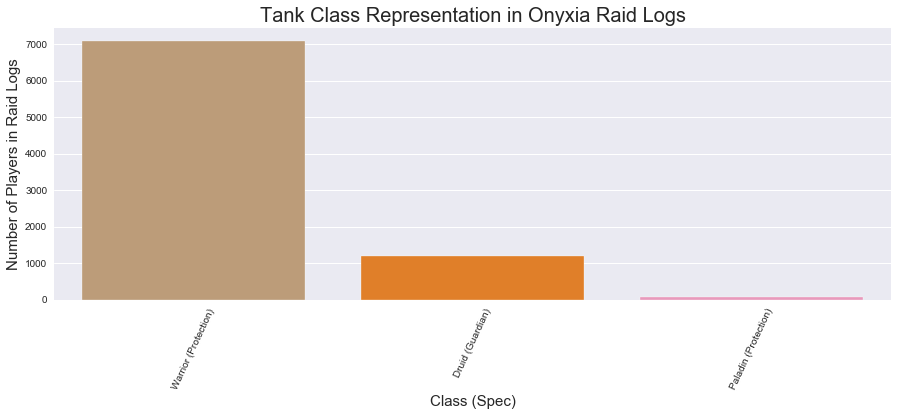

In [145]:
df_class_tank =df_class_tank.sort_values(ascending=False)

# Create an array with the colors you want to use
colors = ['#C79C6E','#FF7D0A','#F58CBA']
customPalette = sns.color_palette(colors)

plt.figure(figsize=(15,5))
chart = sns.barplot(x=df_class_tank.index,
                    y=df_class_tank.values,
                   palette=customPalette)
plt.xlabel("Class (Spec)",size=15)
plt.ylabel("Number of Players in Raid Logs",size=15)
plt.title("Tank Class Representation in Onyxia Raid Logs", size=20)
chart.set_xticklabels(chart.get_xticklabels(), rotation=65)

We again see a class imbalance, as warriors are far and away the best tank in the game as is. While their are in game reasons why we would see less paladins than other classes (they are only playable on alliance) the fact that we see almost none is telling.

In an RPG where players value customization and the ability to play their class of choice, it is unfortunate that players who enjoy the tanking aspect of the game are largely going to be forced into the warrior class if they want to join group end game content.

# Basic Model

I'll just run a simple one feature model on the whole set and see what we get.

In [171]:
# We will try just using raid size first.
X = df_clean['raid_size']

y= df_clean['fight_time_s']


# Create the model with an intercept.
model_simple = sm.OLS(y, X, hasconst=True) 

#Fit
fit = model_simple.fit()

#Print out summary
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           fight_time_s   R-squared:                      -0.869
Model:                            OLS   Adj. R-squared:                 -0.869
Method:                 Least Squares   F-statistic:                       nan
Date:                Sun, 11 Oct 2020   Prob (F-statistic):                nan
Time:                        12:16:55   Log-Likelihood:                -27579.
No. Observations:                4103   AIC:                         5.516e+04
Df Residuals:                    4102   BIC:                         5.517e+04
Df Model:                           0                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
raid_size      9.8673      0.106     92.759      0.000       9.659      10.076
==============================================================================
Omnibus:                      214.410   Durbin-Watson:                   1.717
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              247.974
Skew:                           0.597   Prob(JB):                     1.42e-54
Kurtosis:                       3.163   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

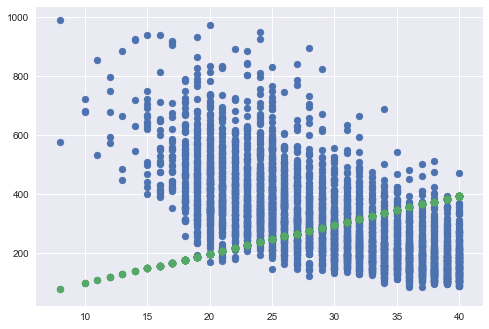

In [172]:
chrt = plt.scatter(df_clean['raid_size'],df_clean['fight_time_s'])
plt.scatter(df_clean['raid_size'],fit.predict())

I am honestly not sure how it got this so wrong. I will try a few more features.

# A Few More Features

In [328]:

# Choose just the X1 column for our data
X = df_clean[['tank_avg_ilvl',
              'heals_avg_ilvl',
              'dps_avg_ilvl',
              'world_buffs',
              'raid_size',
              'dps_num',
              'tank_num',
              'heals_num',
              'world_buff_sqrt',
              'attempts']]

y=df_clean['fight_time_s']
# Choose the response variable
lm_2 = sm.OLS(y, X, hasconst=True)  # Notice that `y` is first here

lm_2 = lm_2.fit()

# summarize our model
lm_2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           fight_time_s   R-squared:                       0.423
Model:                            OLS   Adj. R-squared:                  0.422
Method:                 Least Squares   F-statistic:                     334.0
Date:                Sun, 11 Oct 2020   Prob (F-statistic):               0.00
Time:                        14:13:59   Log-Likelihood:                -25166.
No. Observations:                4103   AIC:                         5.035e+04
Df Residuals:                    4093   BIC:                         5.042e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
tank_avg_ilvl       1.9659      0.770      2.554      0.011       0.457       3.475
heals_avg_ilvl     15.4112      1.316     11.712      0.000      12.831      17.991
dps_avg_ilvl       -7.0809      1.405     -5.041      0.000      -9.835      -4.327
world_buffs         2.2211      0.358      6.197      0.000       1.518       2.924
raid_size         -12.3293      2.690     -4.584      0.000     -17.603      -7.056
dps_num            -4.6317      2.744     -1.688      0.092     -10.012       0.749
tank_num            8.0620      3.219      2.505      0.012       1.752      14.372
heals_num           8.9479      2.986      2.997      0.003       3.094      14.801
world_buff_sqrt   -36.6968      2.476    -14.818      0.000     -41.552     -31.842
attempts           11.8391      2.567      4.613      0.000       6.807      16.871
==============================================================================
Omnibus:                      681.372   Durbin-Watson:                   1.703
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1289.649
Skew:                           1.027   Prob(JB):                    9.04e-281
Kurtosis:                       4.823   Cond. No.                         377.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

It seems counter intuitive to me that the number of healers would necessarily increase expected time, the same goes for their average item level. the others do make more sense to me. It is interesting that world buffs sqrt has such a large weight here. 

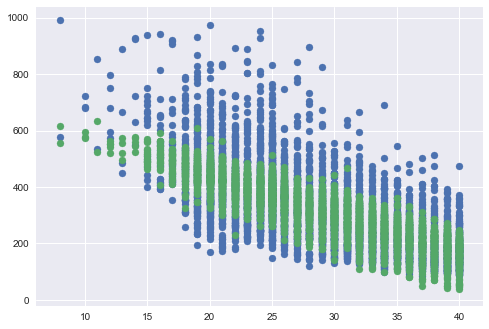

In [329]:
chrt = plt.scatter(df_clean['raid_size'],df_clean['fight_time_s'])
plt.scatter(df_clean['raid_size'],lm_2.predict())

In [330]:
res_s = abs(df_clean['fight_time_s'] - lm_2.predict())
print(np.median(res_s))


69.83300744130025


Ok, that seems a bit better but we still have a fairly large median absolute error of over a minute. I do want to see if using the log of time helps as well.

In [331]:

# Choose just the X1 column for our data
X = df_clean[['tank_avg_ilvl',
              'heals_avg_ilvl',
              'dps_avg_ilvl',
              'world_buffs',
              'raid_size',
              'dps_num',
              'tank_num',
              'heals_num',
              'world_buff_sqrt',
              'attempts']]

y= np.log(df_clean['fight_time_s'])
# Choose the response variable
lm_2_log = sm.OLS(y, X, hasconst=True)  # Notice that `y` is first here

lm_2_log = lm_2_log.fit()

# summarize our model
lm_2_log.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           fight_time_s   R-squared:                       0.105
Model:                            OLS   Adj. R-squared:                  0.103
Method:                 Least Squares   F-statistic:                     53.22
Date:                Sun, 11 Oct 2020   Prob (F-statistic):           5.53e-92
Time:                        14:14:15   Log-Likelihood:                -2394.4
No. Observations:                4103   AIC:                             4809.
Df Residuals:                    4093   BIC:                             4872.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
tank_avg_ilvl       0.0134      0.003      4.469      0.000       0.008       0.019
heals_avg_ilvl      0.0733      0.005     14.324      0.000       0.063       0.083
dps_avg_ilvl        0.0155      0.005      2.837      0.005       0.005       0.026
world_buffs         0.0100      0.001      7.146      0.000       0.007       0.013
raid_size          -0.0076      0.010     -0.730      0.465      -0.028       0.013
dps_num            -0.0440      0.011     -4.123      0.000      -0.065      -0.023
tank_num           -0.0047      0.013     -0.379      0.705      -0.029       0.020
heals_num           0.0015      0.012      0.126      0.900      -0.021       0.024
world_buff_sqrt    -0.1881      0.010    -19.541      0.000      -0.207      -0.169
attempts            0.0580      0.010      5.814      0.000       0.038       0.078
==============================================================================
Omnibus:                        5.111   Durbin-Watson:                   1.423
Prob(Omnibus):                  0.078   Jarque-Bera (JB):                5.132
Skew:                           0.086   Prob(JB):                       0.0768
Kurtosis:                       2.983   Cond. No.                         377.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

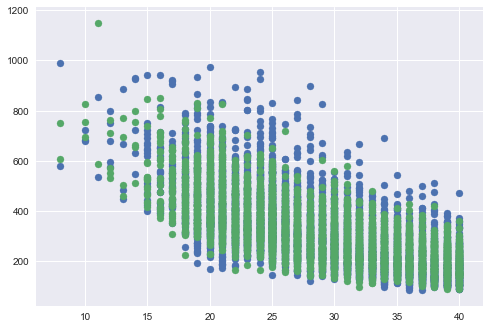

In [332]:
chrt = plt.scatter(df_clean['raid_size'],df_clean['fight_time_s'])
plt.scatter(df_clean['raid_size'],np.exp(lm_2_log.predict()))

In [333]:
res_s = abs(df_clean['fight_time_s'] - np.exp(lm_2_log.predict()))
print(np.median(res_s))


82.94262098109812


It seems that using the log is slightly worse in this case.

Something I want to try through is using polynomial features, mainly because I would expect there to be certain class interactions that would be beneficial to capture. 

For example, Warlocks have an ability that increases the damage that frost mages do. other interactions could be using the average ilvl on certain classes that scale well with gear.

# Polynomial Features and Lasso

I'd like to also start splitting the data for testing as we start to try and find an optimal model.

In [334]:
# Take a subset of columns that seem more important as well as the classes to see if we can identify some useful 
# interaction terms

polydat= df_clean[['Hunter (Marksmanship)',
                                'Mage (Frost)',
                                'Rogue (Assassination)',
                                'Warlock (Destruction)',
                                'Warrior (Fury)',
                                'Mage (Fire)',
                                'Druid (Balance)',
                                'Priest (Shadow)',
                                'Shaman (Enhancement)',
                                'Paladin (Retribution)',
                                'Shaman (Elemental)',
                                'Warrior (Protection)',
                                'Druid (Guardian)',
                                'Paladin (Protection)',
                                'Druid (Restoration)',
                                'Paladin (Holy)',
                                'Priest (Holy)',
                                'Shaman (Restoration)',
                                'tank_avg_ilvl',
                                'heals_avg_ilvl',
                                'dps_avg_ilvl',
                                'world_buff_sqrt',
                                'raid_size',
                                'attempts']]
X = polydat

y=df_clean['fight_time_s']

# split into a test and train set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=40)

# perform a polynomial features transform of the dataset
trans = PolynomialFeatures(degree=2,interaction_only=False)
X_train_poly = trans.fit_transform(X_train)
s=StandardScaler(with_mean=False)
X_train_poly_scaled = s.fit_transform(X_train_poly)

Now we can try a lasso model to try and reduce the features and identify useful ones.

In [336]:
# use lasso CV to find a proper alpha
lasso_model = LassoCV(cv=5, max_iter=6000)
lasso_model.fit(X_train_poly_scaled, y_train)

# print the R squared score for the training set.
print('Train R^2: ',lasso_model.score(X_train_poly_scaled, y_train))

# predict on the test set using the lasso model.
test_set_pred = lasso_model.predict(s.transform(trans.transform(X_test)))

#Median Absolute Error (MAE)
def mae(y_true, y_pred):
    return np.median(np.abs(y_pred - y_true)) 

# Print median absolute error of test set and R squared score of test set.
print('Median Absolute Error (s): ',mae(y_test,test_set_pred))
print('Test R^2: ', r2_score(y_test, test_set_pred))

Train R^2:  0.678484710712432
Median Absolute Error (s):  51.27008200204841
Test R^2:  0.6253037435026243


A bit better than the previous model so that is a good sign. I do want to try a log of y version again as well. So I will just quickly make a few changes to the above. I added a seed so we can compare the same data this time but with log.

In [361]:
# Take a subset of columns that seem more important as well as the classes to see if we can identify some useful 
# interaction terms

polydat= df_clean[['Hunter (Marksmanship)',
                                'Mage (Frost)',
                                'Rogue (Assassination)',
                                'Warlock (Destruction)',
                                'Warrior (Fury)',
                                'Mage (Fire)',
                                'Druid (Balance)',
                                'Priest (Shadow)',
                                'Shaman (Enhancement)',
                                'Paladin (Retribution)',
                                'Shaman (Elemental)',
                                'Warrior (Protection)',
                                'Druid (Guardian)',
                                'Paladin (Protection)',
                                'Druid (Restoration)',
                                'Paladin (Holy)',
                                'Priest (Holy)',
                                'Shaman (Restoration)',
                                'tank_avg_ilvl',
                                'heals_avg_ilvl',
                                'dps_avg_ilvl',
                                'world_buff_sqrt',
                                'raid_size',
                                'attempts']]
X = polydat

y_log = np.log(df_clean['fight_time_s'])

# split into a test and train set
X_train, X_test, y_train, y_test = train_test_split(X, y_log, test_size=0.33, random_state=40)

# perform a polynomial features transform of the dataset
trans_log = PolynomialFeatures(degree=2,interaction_only=False)
X_train_poly = trans_log.fit_transform(X_train)
s=StandardScaler(with_mean=False)
X_train_poly_scaled = s.fit_transform(X_train_poly)

In [362]:
# use lasso CV to find a proper alpha
lasso_model_log = LassoCV(cv=5, max_iter=5000)
lasso_model_log.fit(X_train_poly_scaled, y_train)

# print the R squared score for the training set.
print('Train R^2: ',lasso_model_log.score(X_train_poly_scaled, y_train))

# predict on the test set using the lasso model.
test_set_pred = lasso_model_log.predict(s.transform(trans_log.transform(X_test)))

#Median Absolute Error (MAE)
def mae(y_true, y_pred):
    return np.median(np.abs(y_pred - y_true)) 

# Print median absolute error of test set and R squared score of test set.
print('Median Absolute Error (s): ',mae(np.exp(y_test),np.exp(test_set_pred)))
print('Test R^2: ', r2_score(y_test, test_set_pred))

Train R^2:  0.7602769430987798
Median Absolute Error (s):  45.2571076841528
Test R^2:  0.7084119298560294


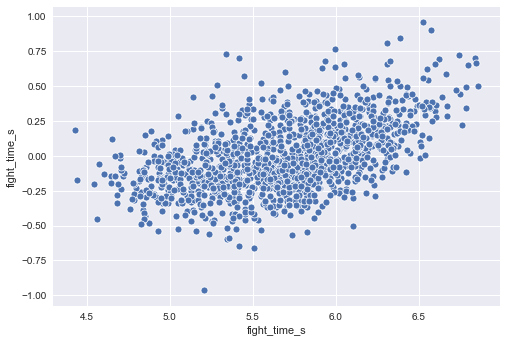

In [340]:
res = (y_test - test_set_pred)
sns.scatterplot(y_test,res)

Using the log transformation we did manage to get a noticeable bump in performance to both metrics. Our residuals do not seem to be uncorrelated to the predicted values of fight time however. I'd like to take a look at what interactions seem to work well. 

In [341]:
lasso_features = list(zip(trans.get_feature_names(X_train.columns), lasso_model.coef_))

In [342]:
kept_features= []
for i in range(0,len(lasso_features)):
    if lasso_features[i][1]==0:
        pass
    else:
        kept_features.append(lasso_features[i])

In [343]:
kept_features

[('Druid (Restoration)', 0.025704763873673833),
 ('Paladin (Holy)', -0.030000157648838434),
 ('Priest (Holy)', 0.028389726810483545),
 ('tank_avg_ilvl', -0.014062279054855393),
 ('dps_avg_ilvl', -0.09376044386318962),
 ('Hunter (Marksmanship)^2', 0.005003041531994347),
 ('Hunter (Marksmanship) Rogue (Assassination)', -0.011030200133783565),
 ('Hunter (Marksmanship) Warrior (Fury)', 0.014613051290694307),
 ('Hunter (Marksmanship) Mage (Fire)', 0.0057111181190307395),
 ('Hunter (Marksmanship) Priest (Shadow)', -0.006074026906808044),
 ('Hunter (Marksmanship) Paladin (Retribution)', -0.002084672663700416),
 ('Hunter (Marksmanship) Shaman (Elemental)', -0.012573156166011875),
 ('Hunter (Marksmanship) Druid (Guardian)', -0.008393807495034105),
 ('Hunter (Marksmanship) Paladin (Protection)', 0.004507793678979963),
 ('Hunter (Marksmanship) Druid (Restoration)', 0.0020888535556416316),
 ('Hunter (Marksmanship) Priest (Holy)', 0.014449062964536206),
 ('Hunter (Marksmanship) Shaman (Restoration)

## Double Lasso Feature Selection

I was reading a paper about a process of feature selection where by you can take the interactions from the first lasso and then them through a second lasso regression against the main X term and see what features remain and add them to a linear regression. Id like to see how this works out.

The paper can be found [here](http://home.uchicago.edu/ourminsky/Variable_Selection.pdf)

In [344]:
hunter_d = X_train[['Rogue (Assassination)',
                   'Warrior (Fury)',
                   'Mage (Fire)',
                   'Priest (Shadow)',
                   'Paladin (Retribution)',
                   'Shaman (Elemental)',
                   'Druid (Guardian)',
                   'Paladin (Protection)',
                   'Druid (Restoration)',
                   'Priest (Holy)',
                   'Shaman (Restoration)',
                   'world_buff_sqrt']]

# scale data
s=StandardScaler(with_mean=False)
hunt_scaled = s.fit_transform(hunter_d)

hunter_y= X_train['Hunter (Marksmanship)']

hunter_model = LassoCV(cv=5, max_iter=5000)
hunter_model.fit(hunt_scaled, hunter_y)

LassoCV(alphas=None, copy_X=True, cv=5, eps=0.001, fit_intercept=True,
        max_iter=5000, n_alphas=100, n_jobs=None, normalize=False,
        positive=False, precompute='auto', random_state=None,
        selection='cyclic', tol=0.0001, verbose=False)

In [345]:
list(zip(hunter_d.columns, hunter_model.coef_))

[('Rogue (Assassination)', 0.04606675581114812),
 ('Warrior (Fury)', 0.0),
 ('Mage (Fire)', -0.011522297604621876),
 ('Priest (Shadow)', 0.0),
 ('Paladin (Retribution)', 0.0826132516734532),
 ('Shaman (Elemental)', 0.0),
 ('Druid (Guardian)', 0.0),
 ('Paladin (Protection)', 0.02459465136831373),
 ('Druid (Restoration)', 0.11400567976148634),
 ('Priest (Holy)', 0.2606857307193306),
 ('Shaman (Restoration)', -0.015777765271475692),
 ('world_buff_sqrt', -0.012959274521554735)]

I will add these interactions that have remained through both lasso iterations to our original linear model with a few broad features and see if there is any noticeable improvement.

In [348]:
df_double_lasso = df_clean[['tank_avg_ilvl',
                            'heals_avg_ilvl',
                            'dps_avg_ilvl',
                            'world_buffs',
                            'raid_size',
                            'dps_num',
                            'tank_num',
                            'heals_num',
                            'world_buff_sqrt',
                            'attempts',
                            'Rogue (Assassination)',
                            'Warrior (Fury)',
                            'Mage (Fire)',
                            'Priest (Shadow)',
                            'Paladin (Retribution)',
                            'Shaman (Elemental)',
                            'Druid (Guardian)',
                            'Paladin (Protection)',
                            'Druid (Restoration)',
                            'Priest (Holy)',
                            'Shaman (Restoration)',
                            'Hunter (Marksmanship)']]

df_double_lasso['hunt_rogue'] = df_double_lasso['Hunter (Marksmanship)']*df_double_lasso['Rogue (Assassination)']
df_double_lasso['hunt_fmage'] = df_double_lasso['Hunter (Marksmanship)']*df_double_lasso['Mage (Fire)']
df_double_lasso['hunt_retpal'] = df_double_lasso['Hunter (Marksmanship)']*df_double_lasso['Paladin (Retribution)']
df_double_lasso['hunt_protpal'] = df_double_lasso['Hunter (Marksmanship)']*df_double_lasso['Paladin (Protection)']
df_double_lasso['hunt_rdruid'] = df_double_lasso['Hunter (Marksmanship)']*df_double_lasso['Druid (Restoration)']
df_double_lasso['hunt_hpriest'] = df_double_lasso['Hunter (Marksmanship)']*df_double_lasso['Priest (Holy)']
df_double_lasso['hunt_rsham'] = df_double_lasso['Hunter (Marksmanship)']*df_double_lasso['Shaman (Restoration)']
df_double_lasso['hunt_wbsqrt'] = df_double_lasso['Hunter (Marksmanship)']*df_double_lasso['world_buff_sqrt']


# Choose just the X1 column for our data
X = df_double_lasso[['tank_avg_ilvl',
                      'heals_avg_ilvl',
                      'dps_avg_ilvl',
                      'world_buffs',
                      'raid_size',
                      'dps_num',
                      'tank_num',
                      'heals_num',
                      'world_buff_sqrt',
                      'attempts',
                      'hunt_rogue',
                      'hunt_fmage',
                      'hunt_retpal',
                      'hunt_protpal',
                      'hunt_rdruid',
                      'hunt_hpriest',
                      'hunt_rsham',
                      'hunt_wbsqrt']]

y=df_clean['fight_time_s']

# Choose the response variable
lm_dbl_lasso = sm.OLS(y, X, hasconst=True)  # Notice that `y` is first here

lm_dbl_lasso = lm_dbl_lasso.fit()

# summarize our model
lm_dbl_lasso.summary()

C:\Users\atag3\anaconda3\lib\site-packages\ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\atag3\anaconda3\lib\site-packages\ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\atag3\anaconda3\lib\site-packages\ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pand

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           fight_time_s   R-squared:                       0.445
Model:                            OLS   Adj. R-squared:                  0.443
Method:                 Least Squares   F-statistic:                     192.9
Date:                Sun, 11 Oct 2020   Prob (F-statistic):               0.00
Time:                        14:16:37   Log-Likelihood:                -25087.
No. Observations:                4103   AIC:                         5.021e+04
Df Residuals:                    4085   BIC:                         5.032e+04
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
tank_avg_ilvl       1.9891      0.761      2.614      0.009       0.497       3.481
heals_avg_ilvl     14.6953      1.312     11.197      0.000      12.122      17.268
dps_avg_ilvl       -5.9782      1.393     -4.292      0.000      -8.709      -3.247
world_buffs         1.9384      0.357      5.434      0.000       1.239       2.638
raid_size         -13.8662      2.664     -5.205      0.000     -19.089      -8.643
dps_num            -2.9002      2.729     -1.063      0.288      -8.250       2.450
tank_num            6.3325      3.181      1.991      0.047       0.096      12.569
heals_num           4.7895      3.015      1.589      0.112      -1.121      10.700
world_buff_sqrt   -36.8511      3.254    -11.324      0.000     -43.231     -30.471
attempts           10.8444      2.526      4.294      0.000       5.893      15.796
hunt_rogue         -2.0435      0.404     -5.063      0.000      -2.835      -1.252
hunt_fmage         -6.4680      0.909     -7.113      0.000      -8.251      -4.685
hunt_retpal         3.5807      1.242      2.884      0.004       1.146       6.015
hunt_protpal        4.8421      3.598      1.346      0.179      -2.213      11.897
hunt_rdruid         4.1921      0.615      6.817      0.000       2.986       5.398
hunt_hpriest        2.3767      0.415      5.731      0.000       1.564       3.190
hunt_rsham          0.7574      0.374      2.026      0.043       0.025       1.490
hunt_wbsqrt         1.4044      0.811      1.731      0.083      -0.186       2.995
==============================================================================
Omnibus:                      683.816   Durbin-Watson:                   1.726
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1300.315
Skew:                           1.028   Prob(JB):                    4.37e-283
Kurtosis:                       4.838   Cond. No.                         383.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

While it is interesting that these features do seem to have helped the model, and many of them are labeled as having some significance I think for the project I will abandon this approach. It takes a lot of effort and code to run through this for all of the features we would need and we have a tight deadline.

# Ensemble Model?

Perhaps it would be helpful to use a linear model for the more general terms and a lasso model to try and capture more of the interactions separately. Then we can use a linear model on the two predictions to try and come up with a better model.

In [351]:
#we need to split the data first

X = df_clean.drop('fight_time_s',axis=1,inplace=False)
y=np.log(df_clean['fight_time_s'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)

# Linear Model
X_t_lm =X_train[['tank_avg_ilvl',
              'heals_avg_ilvl',
              'dps_avg_ilvl',
              'raid_size',
              'dps_num',
              'tank_num',
              'heals_num',
              'world_buff_sqrt',
              'attempts']]



y_t_lm= y_train



# Choose the response variable
lm_4 = sm.OLS(y_t_lm,X_t_lm,hasconst=True)  # Notice that `y` is first here

lm_4 = lm_4.fit()




##### Lasso on classes
X_t_lasso =X_train[['Hunter (Marksmanship)',
                                'Mage (Frost)',
                                'Rogue (Assassination)',
                                'Warlock (Destruction)',
                                'Warrior (Fury)',
                                'Mage (Fire)',
                                'Druid (Balance)',
                                'Priest (Shadow)',
                                'Shaman (Enhancement)',
                                'Paladin (Retribution)',
                                'Shaman (Elemental)',
                                'Warrior (Protection)',
                                'Druid (Guardian)',
                                'Paladin (Protection)',
                                'Druid (Restoration)',
                                'Paladin (Holy)',
                                'Priest (Holy)',
                                'Shaman (Restoration)',
                                'tank_avg_ilvl',
                                'heals_avg_ilvl',
                                'dps_avg_ilvl',
                                'world_buff_sqrt']]

# perform a polynomial features transform of the dataset
trans = PolynomialFeatures(degree=2,interaction_only=False)
X_train_poly = trans.fit_transform(X_t_lasso)
s=StandardScaler(with_mean=False)
X_train_poly_scaled = s.fit_transform(X_train_poly)

# Choose the response variable
lasso_model = LassoCV(cv=5, max_iter=5000)
lasso_model = lasso_model.fit(X_train_poly_scaled, y_t_lm)

#test_set_pred = lasso_model.predict(s.transform(trans.transform(X_test)))



ens_df = pd.DataFrame(
    {'Lasso':lasso_model.predict(X_train_poly_scaled),
    'LRegression':lm_4.predict(),
    'fight_time_s':y_t_lm})

lm_all = sm.OLS(ens_df['fight_time_s'],ens_df[['LRegression','Lasso']],hasconst=True)  # Notice that `y` is first here

lm_all = lm_all.fit()

# summarize our model



lm_all.summary()



<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           fight_time_s   R-squared:                       0.740
Model:                            OLS   Adj. R-squared:                  0.740
Method:                 Least Squares   F-statistic:                     7828.
Date:                Sun, 11 Oct 2020   Prob (F-statistic):               0.00
Time:                        14:17:42   Log-Likelihood:                 108.22
No. Observations:                2749   AIC:                            -212.4
Df Residuals:                    2747   BIC:                            -200.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
LRegression    -0.0143      0.012     -1.157      0.247      -0.039       0.010
Lasso           1.0143      0.012     82.167      0.000       0.990       1.039
==============================================================================
Omnibus:                       41.117   Durbin-Watson:                   1.967
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               43.155
Skew:                           0.284   Prob(JB):                     4.26e-10
Kurtosis:                       3.233   Cond. No.                         31.5
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Not too bad, it seems to be around where the Lasso alone was however and heavily favors the lasso score. Let's see how it looks on the test set.

In [352]:
# Linear Model Test Set
X_test_lm =X_test[['tank_avg_ilvl',
              'heals_avg_ilvl',
              'dps_avg_ilvl',
              'raid_size',
              'dps_num',
              'tank_num',
              'heals_num',
              'world_buff_sqrt',
              'attempts']]


##### Lasso on classes test set
X_test_lasso =X_test[['Hunter (Marksmanship)',
                                'Mage (Frost)',
                                'Rogue (Assassination)',
                                'Warlock (Destruction)',
                                'Warrior (Fury)',
                                'Mage (Fire)',
                                'Druid (Balance)',
                                'Priest (Shadow)',
                                'Shaman (Enhancement)',
                                'Paladin (Retribution)',
                                'Shaman (Elemental)',
                                'Warrior (Protection)',
                                'Druid (Guardian)',
                                'Paladin (Protection)',
                                'Druid (Restoration)',
                                'Paladin (Holy)',
                                'Priest (Holy)',
                                'Shaman (Restoration)',
                                'tank_avg_ilvl',
                                'heals_avg_ilvl',
                                'dps_avg_ilvl',
                                'world_buff_sqrt']]


In [353]:
ens_df_test = pd.DataFrame(
    {'Lasso':lasso_model.predict(s.transform(trans.transform(X_test_lasso))),
    'LRegression':lm_4.predict(X_test_lm),
    'fight_time_s':y_test})



# summarize our model
y_pred = lm_all.predict(ens_df_test[['Lasso','LRegression']])
res = y_test - y_pred

ss_tot = np.sum( (y_test - y_test.mean())**2 )
ss_res = np.sum( (y_test - y_pred)**2 )

print((1 - ss_res/ss_tot))
print((lm_all.rsquared))

res_s = abs(np.exp(y_test) - np.exp(y_pred))
print(np.median(res_s))

0.055656389620223234
0.7402314385901655
87.39903836883438


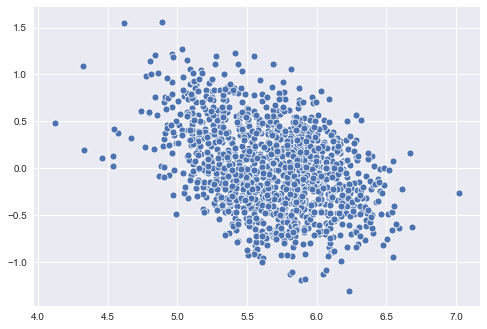

In [355]:
sns.scatterplot(y_pred,res)

Unfortunately the ensemble does not seem to have helped much and has potentially overfit on the training data. There is also clearly some relationship not being captured in the model resulting in correlated residuals to the predicted value.

# Final Model

After trying a few different approaches and swapping variables in ant out, I was unable to find a model that outperformed the Lasso regression with polynomial features. As a final test, I would like to apply it to a new out of sample data set which I collected a week or so after the original set.

In [307]:
holdout_df = pd.read_pickle('wowlogs_holdout.pkl')

We go through the same cleaning process as before.

In [356]:
holdout_df = holdout_df[holdout_df['specs-warcraft.unknown (specs-warcraft.unknown_null)'].isna()]
holdout_df = holdout_df[holdout_df['Mage (specs-warcraft.mage_null)'].isna()]


holdout_df =holdout_df.dropna(axis=1, how='all')

# Create a column with number of attempts extracted from the string.
holdout_df['attempts'] = holdout_df['kill'].apply(lambda x: int(re.findall('\d+', x)[0]) if re.findall('\d+', x) else 1 )

# apply this to the column
holdout_df['kill']=holdout_df['kill'].apply(lambda x:'kill' if re.search('Kill',x) else 'wipe')

# filter the data to include kills only
holdout_df = holdout_df[holdout_df.kill=='kill']

#replace nan with 0, NaNs in our data should generally indicate the absense of a class or even a role (tank/dps/healer)
holdout_df = holdout_df.fillna(0)

# Add Raid size as the total of all present classes in the raid
holdout_df['raid_size'] = holdout_df[['Warrior (Protection)',
                                  'Hunter (Marksmanship)',
                                  'Mage (Frost)',
                                  'Rogue (Assassination)',
                                  'Warlock (Destruction)',
                                  'Warrior (Fury)',
                                  'Druid (Restoration)',
                                  'Paladin (Holy)',
                                  'Priest (Holy)',
                                  #'Mage (Fire)',
                                  'Shaman (Restoration)',
                                  'Druid (Balance)',
                                  'Priest (Shadow)',
                                  'Druid (Guardian)',
                                  'Druid (Feral)',
                                  'Shaman (Enhancement)',
                                  'Paladin (Retribution)',
                                  'Paladin (Protection)',
                                  'Shaman (Elemental)']].sum(axis=1)

# Sum all of the classes that fall into the DPS category
holdout_df['dps_num'] = holdout_df[['Hunter (Marksmanship)',
                                'Mage (Frost)',
                                'Rogue (Assassination)',
                                'Warlock (Destruction)',
                                'Warrior (Fury)',
                                #'Mage (Fire)',
                                'Druid (Balance)',
                                'Priest (Shadow)',
                                'Shaman (Enhancement)',
                                'Paladin (Retribution)',
                                'Shaman (Elemental)']].sum(axis=1)

# Sum all of the classes that fall into the TANK category
holdout_df['tank_num'] = holdout_df[['Warrior (Protection)',
                                  'Druid (Guardian)',
                                  'Paladin (Protection)']].sum(axis=1)

# Sum all of the classes that fall into the HEALER category
holdout_df['heals_num'] = holdout_df[['Druid (Restoration)',
                                  'Paladin (Holy)',
                                  'Priest (Holy)',
                                  'Shaman (Restoration)']].sum(axis=1)

holdout_df['tank_var'] = holdout_df['tank_avg_ilvl']*holdout_df['tank_num']
holdout_df['dps_var'] = holdout_df['dps_avg_ilvl']*holdout_df['dps_num']
holdout_df['heals_var'] = holdout_df['heals_avg_ilvl']*holdout_df['heals_num']

# Find the estimated number fo world buffs per person
holdout_df['buff_pp'] =  holdout_df['world_buffs']/holdout_df['raid_size']
holdout_df['world_buff_sqrt'] = holdout_df['world_buffs']**(1/2)

def get_sec(time_str):
    """Get Seconds from time."""
    m, s = time_str.split(':')
    return int(m) * 60 + int(s)

holdout_df['fight_time_s']=holdout_df['fight_time'].apply(lambda x:get_sec(x))

In [357]:
holdout_df.head()

boss  kill fight_time  tank_avg_ilvl  \
/reports/6gtMvGajpRfcrmx9  Onyxia  kill       2:07           74.5   
/reports/TqMFrjgAyBXKZdpN  Onyxia  kill       2:25           70.5   
/reports/KCbpGDryHdfXmVQP  Onyxia  kill       2:17           75.0   
/reports/8Kwn7VkGLf6vWF9Y  Onyxia  kill       4:08           70.0   
/reports/QzWYrZgKt7aM9fmx  Onyxia  kill       5:15           75.0   

                           dps_avg_ilvl  heals_avg_ilvl  world_buffs  \
/reports/6gtMvGajpRfcrmx9     71.480000          71.500           11   
/reports/TqMFrjgAyBXKZdpN     70.391304          71.250            2   
/reports/KCbpGDryHdfXmVQP     71.296296          72.625           35   
/reports/8Kwn7VkGLf6vWF9Y     69.266667          68.000            6   
/reports/QzWYrZgKt7aM9fmx     66.043478          65.500            0   

                           Warrior (Protection)  Hunter (Marksmanship)  \
/reports/6gtMvGajpRfcrmx9                   2.0                    4.0   
/reports/TqMFrjgAyBXKZdpN                   2.0                    3.0   
/reports/KCbpGDryHdfXmVQP                   2.0                    3.0   
/reports/8Kwn7VkGLf6vWF9Y                   2.0                    1.0   
/reports/QzWYrZgKt7aM9fmx                   1.0                    3.0   

                           Mage (Fire)  ...  raid_size  dps_num  tank_num  \
/reports/6gtMvGajpRfcrmx9          5.0  ...       30.0     20.0       2.0   
/reports/TqMFrjgAyBXKZdpN          3.0  ...       34.0     20.0       2.0   
/reports/KCbpGDryHdfXmVQP          7.0  ...       30.0     19.0       2.0   
/reports/8Kwn7VkGLf6vWF9Y          3.0  ...       22.0     12.0       2.0   
/reports/QzWYrZgKt7aM9fmx          4.0  ...       26.0     19.0       1.0   

                           heals_num  tank_var      dps_var  heals_var  \
/reports/6gtMvGajpRfcrmx9        8.0     149.0  1429.600000      572.0   
/reports/TqMFrjgAyBXKZdpN       12.0     141.0  1407.826087      855.0   
/reports/KCbpGDryHdfXmVQP        8.0     150.0  1354.629630      581.0   
/reports/8Kwn7VkGLf6vWF9Y        8.0     140.0   831.200000      544.0   
/reports/QzWYrZgKt7aM9fmx        6.0      75.0  1254.826087      393.0   

                            buff_pp  world_buff_sqrt  fight_time_s  
/reports/6gtMvGajpRfcrmx9  0.366667         3.316625           127  
/reports/TqMFrjgAyBXKZdpN  0.058824         1.414214           145  
/reports/KCbpGDryHdfXmVQP  1.166667         5.916080           137  
/reports/8Kwn7VkGLf6vWF9Y  0.272727         2.449490           248  
/reports/QzWYrZgKt7aM9fmx  0.000000         0.000000           315  

[5 rows x 38 columns]

In [358]:
holdout_df.shape

(250, 38)

We have an out of sample test with 250 rows to try our `lasso_model_log` model on.

In [363]:
## Test LASSO out of set

polydat_holdout= holdout_df[['Hunter (Marksmanship)',
                                'Mage (Frost)',
                                'Rogue (Assassination)',
                                'Warlock (Destruction)',
                                'Warrior (Fury)',
                                'Mage (Fire)',
                                'Druid (Balance)',
                                'Priest (Shadow)',
                                'Shaman (Enhancement)',
                                'Paladin (Retribution)',
                                'Shaman (Elemental)',
                                'Warrior (Protection)',
                                'Druid (Guardian)',
                                'Paladin (Protection)',
                                'Druid (Restoration)',
                                'Paladin (Holy)',
                                'Priest (Holy)',
                                'Shaman (Restoration)',
                                'tank_avg_ilvl',
                                'heals_avg_ilvl',
                                'dps_avg_ilvl',
                                'world_buff_sqrt',
                                'raid_size',
                                'attempts']]


y_holdout=np.log(holdout_df['fight_time_s'])



l_pred = lasso_model_log.predict(s.transform(trans_log.transform(polydat_holdout)))

res = y_holdout - l_pred

ss_tot = np.sum( (y_holdout - y_holdout.mean())**2 )
ss_res = np.sum( (y_holdout - l_pred)**2 )

print((1 - ss_res/ss_tot))
res_s = abs(np.exp(y_holdout) - np.exp(l_pred))
print(np.median(res_s))

0.7519627598386798
41.754040741959486


The end result on our out of sample set seems to have preformed well with a R squared score of .75 and a median absolute error of 41 seconds.